# Modeling

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm



from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


%matplotlib inline


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter(action="ignore")

In [2]:
df = pd.read_csv('../datasets/exogenous.csv')

In [3]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [4]:
df.shape

(4605, 9)

In [5]:
zip_10002 =df.loc[df['zip_code']==10002]

In [6]:
zip_10002['year_month']=pd.to_datetime(zip_10002['year_month'])

/Users/zhan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
zip_10002.set_index('year_month',inplace = True)
zip_10002 = zip_10002.astype(int)
zip_10002.head()

,zip_code,bait,clean_ups,compliance,initial,sighting,restaurant,population
year_month,,,,,,,,
2010-01-01,10002,8,0,28,91,6,600,79717
2010-02-01,10002,13,0,0,483,3,600,79717
2010-03-01,10002,4,0,73,798,5,600,79717
2010-04-01,10002,10,0,120,321,5,600,79717
2010-05-01,10002,30,0,16,7,9,600,79717


In [8]:
zip_10002.shape

(108, 8)

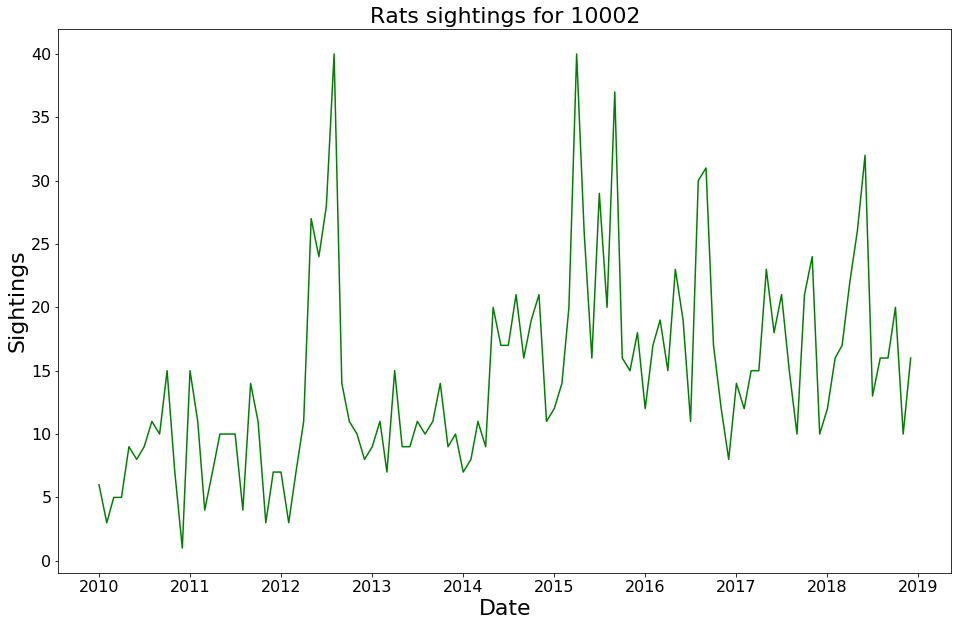

In [9]:
# Set figure size.
plt.figure(figsize=(16,10))

# Create line plot.
plt.plot(zip_10002['sighting'], c ='green')

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Sightings', fontsize=22)
plt.title('Rats sightings for 10002', fontsize=22);

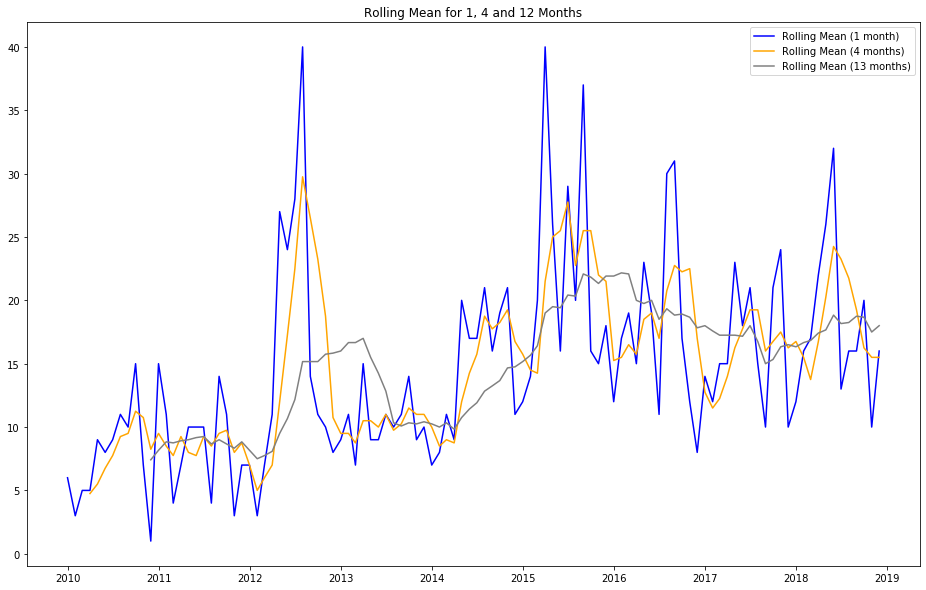

In [10]:
# Set a rolling mean with windows of 1, 4, and 13.
rolmean1  = zip_10002['sighting'].rolling(window = 1).mean()
rolmean4  = zip_10002['sighting'].rolling(window = 4).mean()
rolmean13 = zip_10002['sighting'].rolling(window = 12).mean()

# Plot
plt.figure(figsize=(16,10))
plt.plot(rolmean1, color='blue', label='Rolling Mean (1 month)')
plt.plot(rolmean4, color='orange', label='Rolling Mean (4 months)')
plt.plot(rolmean13, color='grey', label='Rolling Mean (13 months)')

plt.legend(loc='best')

plt.title('Rolling Mean for 1, 4 and 12 Months')
plt.show()

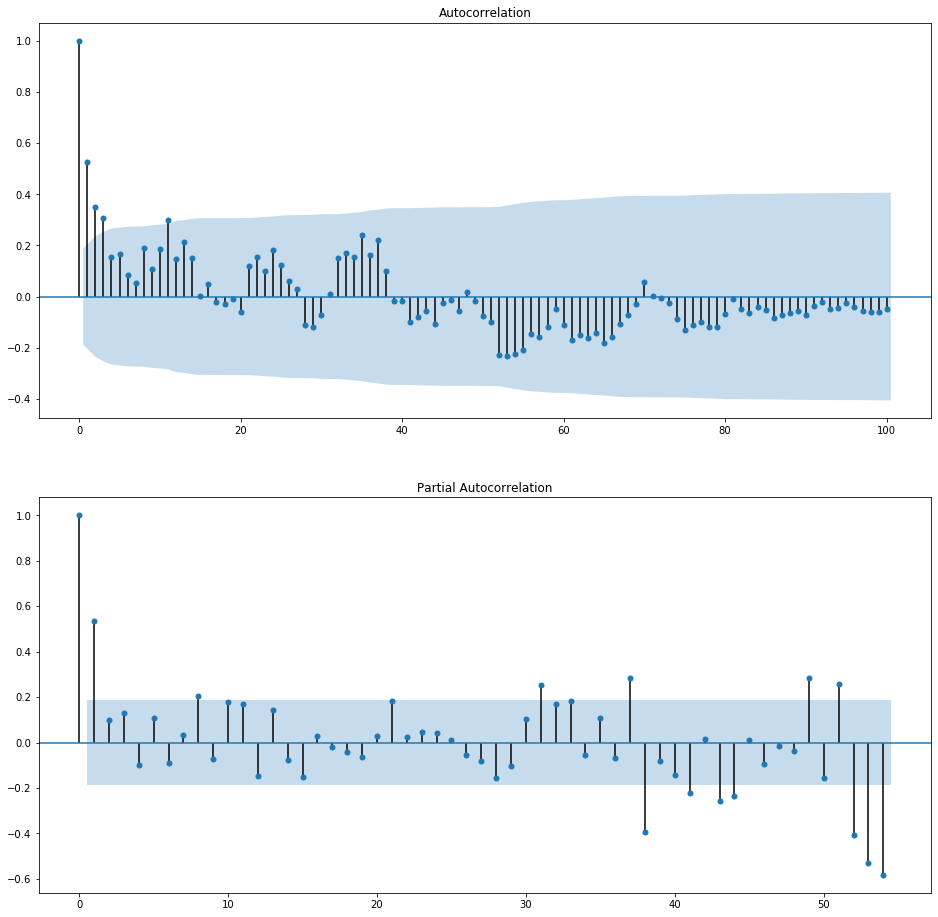

In [27]:
# 52-week  Autocorr and Partial Autocorr
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(zip_10002['sighting'], lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(zip_10002['sighting'], lags=54, ax=ax2);

# If you do not use plt.show() it will plot the same vizualization twice.
# This may be a bug you can fix and submit to contribute to open source!

In [68]:
train = zip_10002[['sighting']].iloc[:96,]
test = zip_10002[['sighting']].iloc[96:,]

In [71]:
train_res = zip_10002[['restaurant']].iloc[:96,]
test_res = zip_10002[['restaurant']].iloc[96:,]

In [72]:
train_pop = zip_10002[['population']].iloc[:96,]
test_pop = zip_10002[['population']].iloc[96:,]

In [73]:
ss = StandardScaler()
Z_train = pd.DataFrame(ss.fit_transform(train), train.index)
Z_test = pd.DataFrame(ss.fit_transform(test), test.index)

Z_train_res = pd.DataFrame(ss.fit_transform(train_res), train.index)
Z_test_res = pd.DataFrame(ss.fit_transform(test_res), test.index)

Z_train_pop = pd.DataFrame(ss.fit_transform(train_pop), train.index)
Z_test_pop = pd.DataFrame(ss.fit_transform(test_pop), test.index)

In [106]:
exog_train = pd.concat([Z_train_res, Z_train_pop], axis = 1)
exog_test = pd.concat([Z_test_res, Z_test_pop], axis = 1)

In [13]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

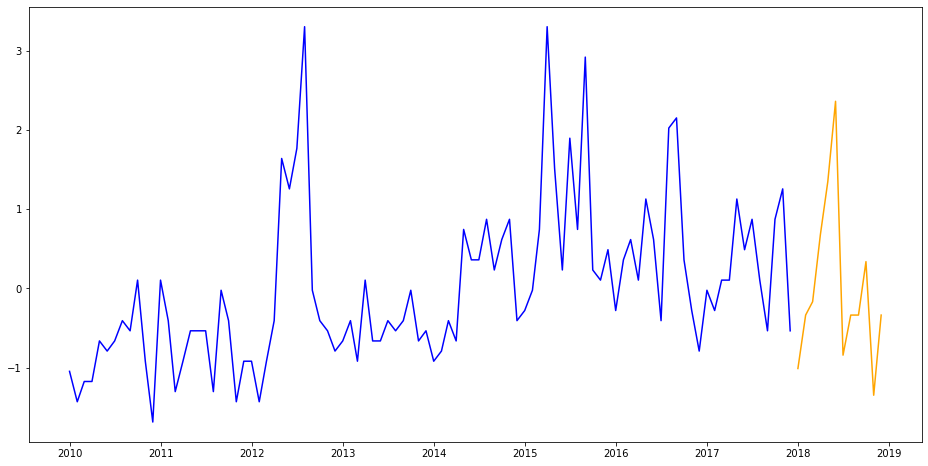

In [74]:
train_test_plot(Z_train, Z_test)

In [88]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [89]:
interpret_dftest(adfuller(zip_10002['sighting']))

Test Statistic   -5.737
p-value           0.000
dtype: float64

In [75]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 0, q) model.
            print(f'Attempting to fit ARIMA({p},0,{q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = Z_train.astype(float).dropna(), # endog = Y variable
                          order = (p,0,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 0, q) model.
            print(f'The AIC for ARIMA({p},0,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},0,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,0,0)
The AIC for ARIMA(0,0,0) is: 276.4361983752972
Attempting to fit ARIMA(0,0,1)
The AIC for ARIMA(0,0,1) is: 252.26745383972434
Attempting to fit ARIMA(0,0,2)
The AIC for ARIMA(0,0,2) is: 253.3732734121975
Attempting to fit ARIMA(0,0,3)
The AIC for ARIMA(0,0,3) is: 246.23462489163919
Attempting to fit ARIMA(0,0,4)
The AIC for ARIMA(0,0,4) is: 247.7655311473013
Attempting to fit ARIMA(1,0,0)
The AIC for ARIMA(1,0,0) is: 245.98992233675642
Attempting to fit ARIMA(1,0,1)
The AIC for ARIMA(1,0,1) is: 246.22903377431055
Attempting to fit ARIMA(1,0,2)
Attempting to fit ARIMA(1,0,3)
The AIC for ARIMA(1,0,3) is: 246.612044082372
Attempting to fit ARIMA(1,0,4)
Attempting to fit ARIMA(2,0,0)
The AIC for ARIMA(2,0,0) is: 246.9177653455003
Attempting to fit ARIMA(2,0,1)
The AIC for ARIMA(2,0,1) is: 249.86117102888483
Attempting to fit ARIMA(2,0,2)
The AIC for ARIMA(2,0,2) is: 246.97233112426042
Attempting to fit ARIMA(2,0,3)
The AIC for ARIMA(2,0,3) is: 248.13150418798

In [76]:
# Our model that minimizes AIC on the training data is the ARIMA(3,0,2):
ARMA3_2 = ARIMA(endog = Z_train.astype(float).dropna(),
                order = (3, 0, 2))
model = ARMA3_2.fit()

In [77]:
pred_train = ARMA3_2.predict(params = model.params,
                         start = Z_train.index[0],
                         end = Z_train.index[-1])
pred_test = ARMA3_2.predict(params = model.params,
                        start = Z_test.index[0],
                        end = Z_test.index[-1])

MSE for training data is 0.6144060138365908
MSE for testing data is 0.9874078445803806


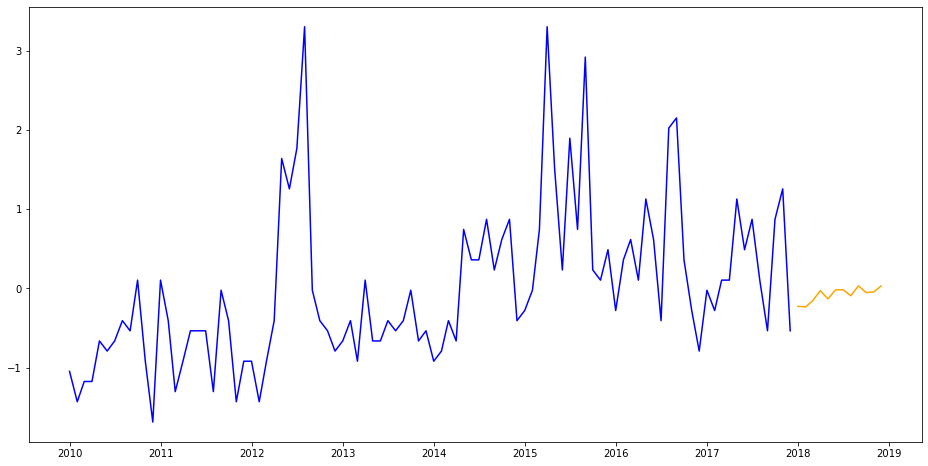

In [78]:
mse_train = mean_squared_error(Z_train, pred_train)
mse_test = mean_squared_error(Z_test, pred_test)
print(f'MSE for training data is {mse_train}')
print(f'MSE for testing data is {mse_test}')

preds = pd.DataFrame(pred_test, index=test.index, columns = ['sighting'])
train_test_plot(Z_train, preds)

In [90]:
import time
t0 = time.time()
final_mse = 10000000000000
final_S = 0
final_D = 0
final_P = 0
final_Q = 0

for S in [37, 38, 49]:
    for D in range(3):
        for P in range(3):
            for Q in range(3):
                print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                try:
                    sarima = SARIMAX(endog = Z_train.dropna(),
                                     order = (3, 0, 2),
                                     seasonal_order = (P, D, Q, S)).fit()

                    sarima_pred = sarima.predict(start = Z_train.index[0], end = Z_train.index[-1])

                    if mean_squared_error(Z_train, sarima_pred) < final_mse:
                        final_mse = mean_squared_error(Z_train, sarima_pred)
                        final_S = S
                        final_D = D
                        final_P = P
                        final_Q = Q

                    print(f'We just fit a SARIMAX(3, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_squared_error(Z_train, sarima_pred)} MSE.')

                except:
                    pass

print(f'The final model is SARIMAX(3, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')

Checking (0, 0, 0, 37) at 0 seconds.
We just fit a SARIMAX(3, 0, 2)x(0, 0, 0, 37) model with 0.614706171671654 MSE.
Checking (0, 0, 1, 37) at 0 seconds.
Checking (0, 0, 2, 37) at 0 seconds.
Checking (1, 0, 0, 37) at 0 seconds.
We just fit a SARIMAX(3, 0, 2)x(1, 0, 0, 37) model with 0.6021833300295146 MSE.
Checking (1, 0, 1, 37) at 3 seconds.
Checking (1, 0, 2, 37) at 3 seconds.
Checking (2, 0, 0, 37) at 3 seconds.
We just fit a SARIMAX(3, 0, 2)x(2, 0, 0, 37) model with 0.6006167892080377 MSE.
Checking (2, 0, 1, 37) at 14 seconds.
Checking (2, 0, 2, 37) at 14 seconds.
Checking (0, 1, 0, 37) at 14 seconds.
We just fit a SARIMAX(3, 0, 2)x(0, 1, 0, 37) model with 0.9773400514860106 MSE.
Checking (0, 1, 1, 37) at 15 seconds.
Checking (0, 1, 2, 37) at 16 seconds.
Checking (1, 1, 0, 37) at 16 seconds.
We just fit a SARIMAX(3, 0, 2)x(1, 1, 0, 37) model with 0.9568621900663565 MSE.
Checking (1, 1, 1, 37) at 27 seconds.
Checking (1, 1, 2, 37) at 27 seconds.
Checking (2, 1, 0, 37) at 27 seconds.


In [103]:
sarimax = SARIMAX(endog = Z_train.dropna(),
                  exog = exog_train.dropna(),
                  order = (3, 0, 2),
                  seasonal_order = (2, 0, 0, 37)).fit()

sarimax_pred_train = sarimax.predict(start = Z_train.index[0], 
                                     end = Z_train.index[-1])

sarimax_pred_test = sarimax.forecast(len(Z_test), 
                                     exog = exog_test.dropna(), 
                                     alpha = 0.05)

preds_train = pd.DataFrame(sarimax_pred_train.values, 
                           index=Z_train.index, columns = ['sighting'])

preds_test = pd.DataFrame(sarimax_pred_test.values, 
                          index=Z_test.index, columns = ['sighting'])

No handles with labels found to put in legend.


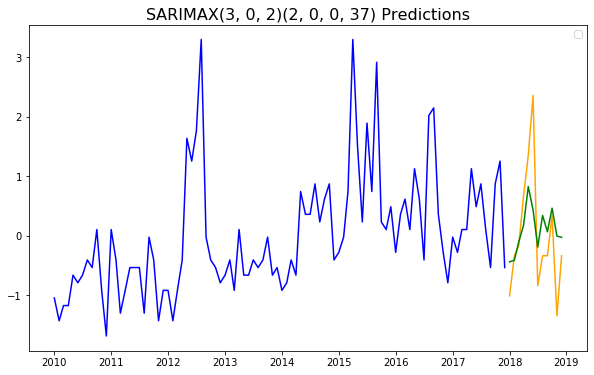

In [121]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(Z_train.index, Z_train, color = 'blue', label = '')

# Plot testing data.
plt.plot(Z_test.index, Z_test, color = 'orange', label = 'testing')

# Plot predicted test values.
plt.plot(Z_test.index, preds_test, color = 'green')

plt.title(label = 'SARIMAX(3, 0, 2)(2, 0, 0, 37) Predictions', fontsize=16)
plt.legend()

plt.show();